In [1]:
import re
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from urllib.parse import urlparse
from sklearn import metrics
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import backend as K
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from sklearn.linear_model import LogisticRegression

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
SIZE = 100
BATCH_SIZE = 16
EPOCHS = 100
SEED = 0

In [3]:
os.environ['PYTHONHASHSEED']=str(SEED)

random.seed(SEED)

np.random.seed(SEED)

tf.random.set_seed(SEED)

In [4]:
df=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_2.csv")
df2=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/mal_3.csv")

In [5]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.drop('label',axis = 1, inplace = True)
df=df.rename(columns={'result': 'type'})

In [6]:
df2=df2.rename(columns={'label': 'type'})
df2['type']=df2['type'].replace({'bad':1,'good':0})

In [7]:
df.head()

,url,type
0,https://www.google.com,0
1,https://www.youtube.com,0
2,https://www.facebook.com,0
3,https://www.baidu.com,0
4,https://www.wikipedia.org,0


In [8]:
df2.head()

,url,type
0,diaryofagameaddict.com,1
1,espdesign.com.au,1
2,iamagameaddict.com,1
3,kalantzis.net,1
4,slightlyoffcenter.net,1


In [9]:
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens=[]
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokentsByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    if 'com' in allTokens:
        allTokens.remove('com')
    return allTokens

In [10]:
#Model--1
data1 = np.array(df)


y1=[d[1] for d in data1]
url1=[d[0] for d in data1]
vectorised_url1=TfidfVectorizer()
x1=vectorised_url1.fit_transform(url1)

x_train1, x_test1, y_train1, y_test1 = train_test_split(x1,y1,test_size=0.2,shuffle='True',stratify=y1)

In [11]:
#Model--2
data2 = np.array(df2)


y2=[d[1] for d in data2]
url2=[d[0] for d in data2]
vectorised_url2=TfidfVectorizer()
x2=vectorised_url2.fit_transform(url2)

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2,y2,test_size=0.2,shuffle='True',stratify=y2)

In [12]:
#Logistic Regression 
model_lg1 = LogisticRegression(solver='lbfgs', max_iter=10000)
model_lg2 = LogisticRegression(solver='lbfgs', max_iter=10000)

#XGBoost 
model_xg1 = xgb.XGBClassifier(n_jobs = 8)
model_xg2 = xgb.XGBClassifier(n_jobs = 8)

#Decision Tree 
model_dc1 = DecisionTreeClassifier()
model_dc2 = DecisionTreeClassifier()

In [13]:
model_lg1.fit(x_train1,y_train1)
score_lg1 = model_lg1.score(x_test1,y_test1)
print(score_lg1)

0.9957572526544938


In [14]:
model_lg2.fit(x_train2,y_train2)
score_lg2 = model_lg2.score(x_test2,y_test2)
print(score_lg2)

0.9647176340480182


In [15]:
model_xg1.fit(x_train1,y_train1)
score_xg1 = model_xg1.score(x_test1,y_test1)
print(score_xg1)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:46] WARNING: /private/var/folders/6t/fjr9gh2x3kzfp_x8d04mv8gm0000gn/T/pip-install-y0vm59pd/xgboost_9fb7486255a9441d88b43152e370bd50/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9980341196854592


In [16]:
model_xg2.fit(x_train2,y_train2)
score_xg2 = model_xg2.score(x_test2,y_test2)
print(score_xg2)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:42] WARNING: /private/var/folders/6t/fjr9gh2x3kzfp_x8d04mv8gm0000gn/T/pip-install-y0vm59pd/xgboost_9fb7486255a9441d88b43152e370bd50/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9387939543124874


In [17]:
model_dc1.fit(x_train1,y_train1)
score_dc1 = model_dc1.score(x_test1,y_test1)
print(score_dc1)

0.9984228530809899


In [18]:
model_dc2.fit(x_train2,y_train2)
score_dc2 = model_dc2.score(x_test2,y_test2)
print(score_dc2)

0.9687607767590644


In [19]:
pred_lg1 = model_lg1.predict(x_test1)
pred_lg2 = model_lg2.predict(x_test2)

pred_xg1 = model_xg1.predict(x_test1)
pred_xg2 = model_xg2.predict(x_test2)

pred_dc1 = model_dc1.predict(x_test1)
pred_dc2 = model_dc2.predict(x_test2)

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
print(classification_report(y_test1,pred_lg1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     69148
           1       1.00      0.98      0.99     20888

    accuracy                           1.00     90036
   macro avg       1.00      0.99      0.99     90036
weighted avg       1.00      1.00      1.00     90036



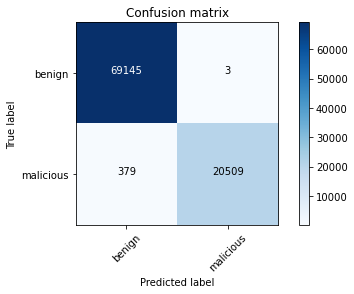

In [22]:
cm = metrics.confusion_matrix(y_test1, pred_lg1, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [23]:
print(classification_report(y_test2,pred_lg2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     68964
           1       0.97      0.83      0.89     15129

    accuracy                           0.96     84093
   macro avg       0.97      0.91      0.94     84093
weighted avg       0.96      0.96      0.96     84093



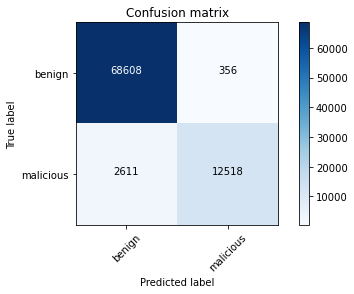

In [24]:
cm = metrics.confusion_matrix(y_test2, pred_lg2, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [25]:
print(classification_report(y_test1,pred_xg1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69148
           1       1.00      0.99      1.00     20888

    accuracy                           1.00     90036
   macro avg       1.00      1.00      1.00     90036
weighted avg       1.00      1.00      1.00     90036



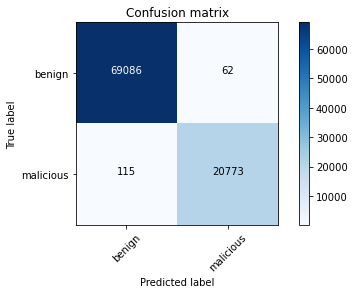

In [26]:
cm = metrics.confusion_matrix(y_test1, pred_xg1, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [27]:
print(classification_report(y_test2,pred_xg2))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     68964
           1       0.93      0.71      0.81     15129

    accuracy                           0.94     84093
   macro avg       0.93      0.85      0.89     84093
weighted avg       0.94      0.94      0.94     84093



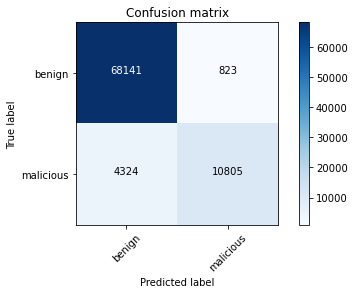

In [28]:
cm = metrics.confusion_matrix(y_test2, pred_xg2, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [29]:
print(classification_report(y_test1,pred_dc1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69148
           1       1.00      1.00      1.00     20888

    accuracy                           1.00     90036
   macro avg       1.00      1.00      1.00     90036
weighted avg       1.00      1.00      1.00     90036



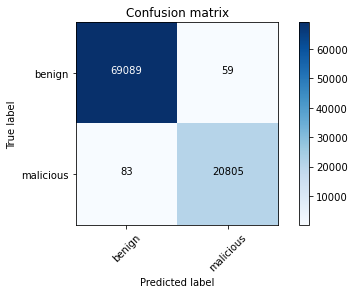

In [30]:
cm = metrics.confusion_matrix(y_test1, pred_dc1, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [31]:
print(classification_report(y_test2,pred_dc2))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     68964
           1       0.94      0.89      0.91     15129

    accuracy                           0.97     84093
   macro avg       0.96      0.94      0.95     84093
weighted avg       0.97      0.97      0.97     84093



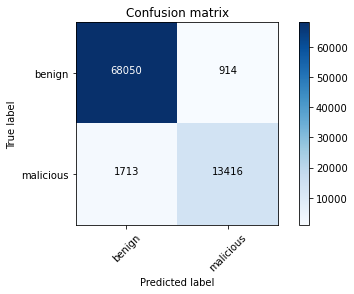

In [32]:
cm = metrics.confusion_matrix(y_test2, pred_dc2, labels=[0,1])
plot_confusion_matrix(cm,classes=['benign','malicious'])

In [33]:
url_test = ['http://www.824555.com/app/member/SportOption.php?uid=guest&langx=gb','http://202.77.121.186/kliping/','crackspider.us/toolbar/install.php?pack=exe','www.google.com']

url_test1 = []
url_test2 = []
for url in url_test:
    if(urlparse(url).scheme != ''):
        url_test1.append(url)
    else:
        url_test2.append(url)

x_pred1=vectorised_url1.transform(url_test1)
x_pred2=vectorised_url2.transform(url_test2)

pred1=model_xg1.predict(x_pred1)
pred2=model_dc2.predict(x_pred2)

In [34]:
pred1

array([1, 1])

In [35]:
pred2

array([1, 0])